In [2]:
import numpy as np
import matplotlib.pyplot as plt #matplob lib
%matplotlib inline
import os

import astropy.io.ascii as at
from scipy.interpolate import griddata, LinearNDInterpolator, interp2d

In [3]:
# read in our MIST isochrone
data = at.read("MIST_iso_67e56fd8ac521.iso.cmd")

# filter out AGB/RGB stars so we're left with just main sequence stars
ms = (data['EEP'] < 605) & (data['log_g'] > 2.0)
data = data[ms]

In [4]:
interp = LinearNDInterpolator(
    list(zip(data['log_Teff'], data['log_g'])), data['initial_mass']
)

<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
C:\Users\Jared\AppData\Local\Temp\ipykernel_15664\3261272432.py:4: SyntaxWarning: invalid escape sequence '\o'
  plt.colorbar(ax.collections[0], label='Mass (M$_\odot$)')


array(nan)

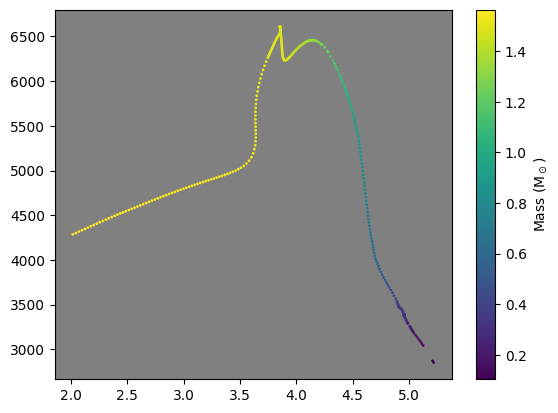

In [38]:
fig, ax = plt.subplots()
ax.scatter(data['log_g'], 10**data['log_Teff'], c=data['initial_mass'], s=1)
ax.set_facecolor('gray')
plt.colorbar(ax.collections[0], label='Mass (M$_\odot$)')
ax.scatter(2.1,5000,c=interp(2.1,5000))
interp(4.0, 6300)

In [ ]:
from scipy.interpolate import CloughTocher2DInterpolator

